## Attempt to sonify flow of syrian refugees
* Data from UN : http://popstats.unhcr.org/en/asylum_seekers_monthly
* Original code (https://github.com/cirlabs/miditime/blob/master/README.md) transforms the magnitude of an event to the pitch and assumes one data point per event.
* Our data is monthly aggregates. So the magnitude (m) needs to translate to the number of notes (n), rather than mapping m -> pitch (p). 
* Otherwise, it will just sound like a steady stream of beeps, with varying pitch if the month has higher/lower number of refugees, but it's hard for the reader to picture.

In [1]:
# My usual setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas 
from datetime import datetime
import seaborn as sns
import glob
from os.path import basename
sns.set_context('poster') 

In [44]:
# miditime libs
from miditime.miditime import MIDITime 
import numpy as np

## Preprocess data 
* group by month and year (multiple entries per country of origin and even several for each then)
* convert data type
* MAKE SURE SORTED

In [3]:
df = pandas.read_csv('../data/SYRIA-unhcr_popstats_export_asylum_seekers_monthly_2010-2017-06.csv', skiprows=2)

In [4]:
df.head()

,Country / territory of asylum/residence,Origin,Year,Month,Value
0,Hungary,Syrian Arab Rep.,2010,January,2
1,Hungary,Syrian Arab Rep.,2010,February,3
2,Hungary,Syrian Arab Rep.,2010,March,1
3,Hungary,Syrian Arab Rep.,2010,April,3
4,Hungary,Syrian Arab Rep.,2010,June,2


In [5]:
#convert to numeric
df['value_numeric'] = pandas.to_numeric(df.Value, errors="coerce")

In [6]:
# not sure why i have to apply first to convert to string, but here we are.
df['datetime'] = pandas.to_datetime(df.apply(lambda x: str(x['Year']) + x['Month'], axis=1), format="%Y%B")

In [7]:
# There are several records per country per month, get lump sum of each month
monthly_totals = df.groupby('datetime').value_numeric.sum()

In [8]:
monthly_totals.head()

datetime
2010-01-01    499.0
2010-02-01    635.0
2010-03-01    519.0
2010-04-01    433.0
2010-05-01    472.0
Name: value_numeric, dtype: float64

In [9]:
len(monthly_totals.index)

91

In [10]:
MIN = monthly_totals.min()
MAX = monthly_totals.max()

In [11]:
print(MIN)
print(MAX)

433.0
102089.0


In [12]:
monthly_totals = monthly_totals.sort_index()

## Save monthly totals — for easy lookup, then re-read as a dataframe. 
You can skip this step, this is for data documenting. It's also a hack to make a nice df.

In [70]:
monthly_totals.to_csv('../data/monthly-totals-syria.csv')

In [87]:
df = pandas.read_csv('../data/monthly-totals-syria.csv', parse_dates=['datetime'])

In [88]:
df.head()

,datetime,magnitude
0,2010-01-01,499.0
1,2010-02-01,635.0
2,2010-03-01,519.0
3,2010-04-01,433.0
4,2010-05-01,472.0


### Chart data

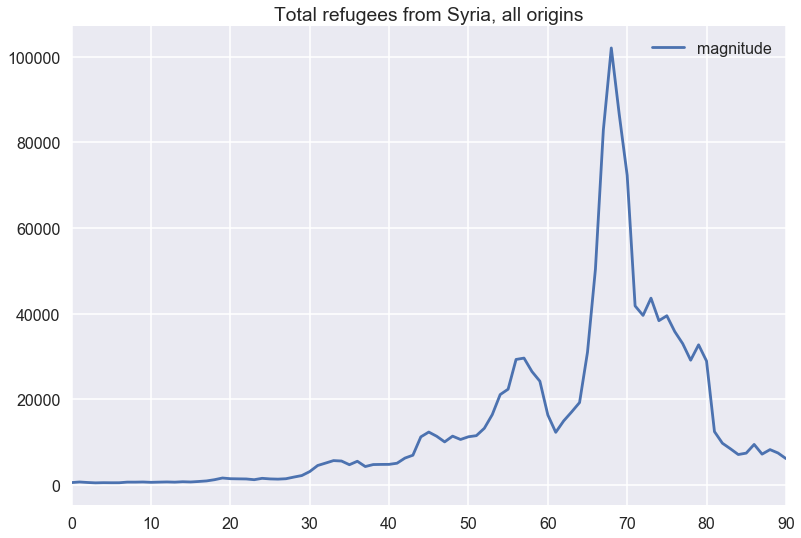

In [93]:
df[['datetime','magnitude']].plot()
plt.title("Total refugees from Syria, all origins")

## Process for MIDI
* CHANGES FROM REVEAL CODE: DO EVERYTHING IN A DF

Instantiate the class with a tempo (120bpm is the default), an output file destination, the number of seconds you want to represent a year in the final song (default is 5 sec/year), the base octave (C5 is middle C, so the default is 5, and how many octaves you want your output to range over (default is 1).

In [94]:
BPM = 120
FILENAME = '../audio/syria-2010-2017-FREQ.mid'
SEC_PER_YEAR = 5
BASE_OCTAVE = 5
OCTAVES = 1

mymidi = MIDITime(BPM,FILENAME, SEC_PER_YEAR, BASE_OCTAVE, OCTAVES)

I save this is as a column, and zip all data later, for easy error checking.
Convert your date/time data into an integer, like days since the epoch (Jan. 1, 1970). You can use the days_since_epoch() helper method, or not:

In [97]:
df['epoched'] = df.datetime.apply(lambda x: mymidi.days_since_epoch(x))

Convert your integer date/time to something reasonable for a song. For example, at 120 beats per minute, you'll need to scale the data down a lot to avoid a very long song if your data spans years. This uses the seconds_per_year attribute you set at the top, so if your date is converted to something other than days you may need to do your own conversion. But if your dataset spans years and your dates are in days (with fractions is fine), use the beat() helper method.

In [99]:
df['beat'] = df['epoched'].apply(lambda x: mymidi.beat(x))

In [102]:
START_TIME = df.beat.min() # beat doesn't start at 0 since we scaled our epoch seconds, so we just start at the first one.
print(START_TIME)

400.0


In [27]:
# WILL DO THIS AT A LATER STYPE
#HACK COZ I COULDNT FIGURE OUT HOW TO CONVERT SERIES TO DICT with PROPER FORMAT
#syria_data = [{'datetime':x, 'magnitude': y} for x, y in zip(monthly_totals.index, monthly_totals.values)]


Set up some functions to scale your other variable (magnitude in our case) to match your desired mode/key and octave range. There are helper methods to assist this scaling, very similar to a charting library like D3. You can choose a linear or logarithmic scale.

## Calculate N, the number of beats we want for a given month, as a function of magnitude.
We use numpy linear interpolation to map. (maybe add logarithmic later.) We don't need to reverse it, because higher number of refugees = more notes.

In [107]:
MIN_N = 1 # how many notes do we want per month min?
MAX_N = 100 # how many notes do we want per month max?

df['N'] = df.magnitude.apply(lambda x: np.interp(x, [MIN,MAX], [MIN_N, MAX_N]))

In [110]:
df.head() 

,datetime,magnitude,epoched,beat,N
0,2010-01-01,499.0,14610.0,400.00,1.064276
1,2010-02-01,635.0,14641.0,400.85,1.196722
2,2010-03-01,519.0,14669.0,401.62,1.083753
3,2010-04-01,433.0,14700.0,402.46,1.000000
4,2010-05-01,472.0,14730.0,403.29,1.037981


## Time to make the note list!
* I know you're not supposed to iterate through a dataframe — but it's pretty small and manegable.
* [BEAT, PITCH, VELOCITY (VOLUME), DURATION_OF_NOTE]


In [122]:
months = df.to_dict('records')

In [125]:
[[['a','b','c']]*5]

[[['a', 'b', 'c'],
  ['a', 'b', 'c'],
  ['a', 'b', 'c'],
  ['a', 'b', 'c'],
  ['a', 'b', 'c']]]

In [130]:
note_list = [] 
P = 71 # for now constant
V = 100

for i in range(len(months)-1):
    start_beat = months[i]['beat']
    end_beat = months[i+1]['beat']
    period = end_beat - start_beat
    
    for n in range(int(months[i]['N'])): # truncate the N to nearest int
        beat = start_beat + (i * period)
        pitch = P 
        velocity = V
        duration = period - (period / 10.0) # do a little offset?
        note_list.append([beat, pitch, velocity, duration])
    

In [131]:
note_list

[[400.0, 71, 100, 0.7650000000000204],
 [401.62, 71, 100, 0.6929999999999836],
 [403.29999999999995, 71, 100, 0.7559999999999775],
 [404.9500000000001, 71, 100, 0.7470000000000369],
 [406.6499999999999, 71, 100, 0.7559999999999775],
 [408.2799999999999, 71, 100, 0.7469999999999857],
 [410.00000000000017, 71, 100, 0.7560000000000286],
 [411.7499999999998, 71, 100, 0.7649999999999693],
 [413.2100000000004, 71, 100, 0.7380000000000451],
 [415.1199999999997, 71, 100, 0.7649999999999693],
 [416.5199999999999, 71, 100, 0.7379999999999939],
 [418.49000000000024, 71, 100, 0.7650000000000204],
 [420.1899999999996, 71, 100, 0.7649999999999693],
 [420.8500000000005, 71, 100, 0.6930000000000348],
 [423.50999999999954, 71, 100, 0.7649999999999693],
 [424.7599999999999, 71, 100, 0.7379999999999939],
 [426.88000000000034, 71, 100, 0.7650000000000204],
 [428.0699999999999, 71, 100, 0.7379999999999939],
 [430.2500000000004, 71, 100, 0.7650000000000204],
 [431.94999999999936, 71, 100, 0.7649999999999693

## Make MIDI file

In [132]:
# Add a track with those notes
mymidi.add_track(note_list)

# Output the .mid file
mymidi.save_midi()

71 400.0 0.7650000000000204 100
71 401.62 0.6929999999999836 100
71 403.29999999999995 0.7559999999999775 100
71 404.9500000000001 0.7470000000000369 100
71 406.6499999999999 0.7559999999999775 100
71 408.2799999999999 0.7469999999999857 100
71 410.00000000000017 0.7560000000000286 100
71 411.7499999999998 0.7649999999999693 100
71 413.2100000000004 0.7380000000000451 100
71 415.1199999999997 0.7649999999999693 100
71 416.5199999999999 0.7379999999999939 100
71 418.49000000000024 0.7650000000000204 100
71 420.1899999999996 0.7649999999999693 100
71 420.8500000000005 0.6930000000000348 100
71 423.50999999999954 0.7649999999999693 100
71 424.7599999999999 0.7379999999999939 100
71 426.88000000000034 0.7650000000000204 100
71 428.0699999999999 0.7379999999999939 100
71 430.2500000000004 0.7650000000000204 100
71 431.94999999999936 0.7649999999999693 100
71 431.94999999999936 0.7649999999999693 100
71 433.050000000001 0.7380000000000451 100
71 435.3199999999993 0.7649999999999693 100
71 43

71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.7650000000000204 100
71 511.0500000000015 0.765000000

71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 527.2900000000038 0.7380000000000451 100
71 531.2699999999974 0.7649999999999693 100
71 531.2699999999974 0.764999999